<a href="https://colab.research.google.com/github/Rakshit358/Food_vision_101_transfer_learning/blob/main/Food_vision_with_Transfer_Learning_pynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Fri Jul  5 16:49:25 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip



--2024-07-05 16:49:26--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.207, 172.217.194.207, 142.250.4.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  21.0MB/s    in 8.7s    

2024-07-05 16:49:35 (18.4 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
import os
for dirpath,dirnames,filename in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filename)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/train
There are 0 directories and 75 images in 10_food_classes_10_percent/train/sushi
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_curry
There are 0 directories and 75 images in 10_food_classes_10_percent/train/grilled_salmon
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ramen
There are 0 directories and 75 images in 10_food_classes_10_percent/train/pizza
There are 0 directories and 75 images in 10_food_classes_10_percent/train/fried_rice
There are 0 directories and 75 images in 10_food_classes_10_percent/train/ice_cream
There are 0 directories and 75 images in 10_food_classes_10_percent/train/chicken_wings
There are 0 directories and 75 images in 10_food_classes_10_percent/train/hamburger
There are 0 directories and 75 images in 10_food_classes_10_percent/train/steak
There are 10 director

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
IMG_SHAPE = (224,224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                              target_size=IMG_SHAPE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode="categorical")

print("Testing images:")
test_data_10_percent = test_datagen.flow_from_directory(test_dir,
                                                              target_size=IMG_SHAPE,
                                                              batch_size=BATCH_SIZE,
                                                              class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving Tensorboard log files to: {log_dir}")
  return tensorboard_callback


In [ ]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url,num_classes=10):
  feature_extractor_layer = hub.KerasLayer(model_url,trainable=False,input_shape=IMG_SHAPE+(3,))
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes,activation="softmax",name="output_layer")
  ])
  return model


In [ ]:
resnet_model = create_model(resnet_url)
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [ ]:
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [ ]:
history_1 = resnet_model.fit(train_data_10_percent,
                             epochs=5,steps_per_epoch=len(train_data_10_percent),
                             validation_data=test_data_10_percent,
                             callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                   experiment_name="resnet50v2")])

Saving Tensorboard log files to: tensorflow_hub/resnet50v2/20240705-164950
Epoch 1/5
24/24 [==============================] - 22s 599ms/step - loss: 1.8534 - accuracy: 0.3720 - val_loss: 1.2162 - val_accuracy: 0.6040
Epoch 2/5
24/24 [==============================] - 11s 454ms/step - loss: 0.9002 - accuracy: 0.7200 - val_loss: 0.8796 - val_accuracy: 0.7116
Epoch 3/5
24/24 [==============================] - 11s 466ms/step - loss: 0.6180 - accuracy: 0.8227 - val_loss: 0.7665 - val_accuracy: 0.7400
Epoch 4/5
24/24 [==============================] - 11s 473ms/step - loss: 0.4727 - accuracy: 0.8880 - val_loss: 0.7085 - val_accuracy: 0.7604
Epoch 5/5
24/24 [==============================] - 13s 546ms/step - loss: 0.3743 - accuracy: 0.9240 - val_loss: 0.6788 - val_accuracy: 0.7708


In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))
  plt.plot(epochs,loss,label="training_loss")
  plt.plot(epochs,val_loss,label="val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs,accuracy,label="training_accuracy")
  plt.plot(epochs,val_accuracy,label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()


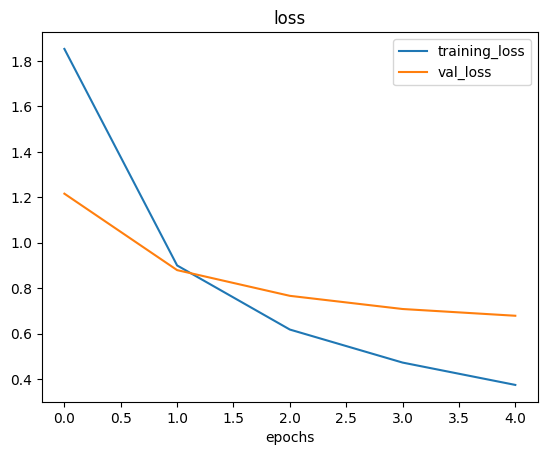

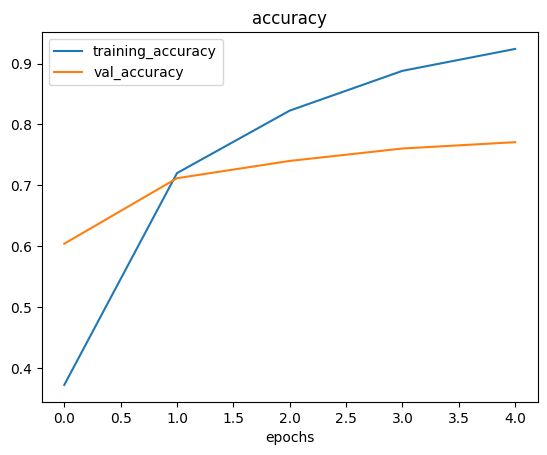

In [ ]:
plot_loss_curves(history_1)

In [ ]:
efficientnet_model = create_model(efficientnet_url)

efficientnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

history_2 = efficientnet_model.fit(train_data_10_percent,
                       epochs=5,
                       steps_per_epoch=len(train_data_10_percent),
                       validation_data=test_data_10_percent,
                       callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                             experiment_name="efficientnetb0")])


Saving Tensorboard log files to: tensorflow_hub/efficientnetb0/20240705-165543
Epoch 1/5
24/24 [==============================] - 21s 495ms/step - loss: 1.8792 - accuracy: 0.4147 - val_loss: 1.3458 - val_accuracy: 0.7272
Epoch 2/5
24/24 [==============================] - 10s 447ms/step - loss: 1.0947 - accuracy: 0.7720 - val_loss: 0.8926 - val_accuracy: 0.8152
Epoch 3/5
24/24 [==============================] - 13s 539ms/step - loss: 0.7758 - accuracy: 0.8293 - val_loss: 0.7149 - val_accuracy: 0.8428
Epoch 4/5
24/24 [==============================] - 10s 438ms/step - loss: 0.6222 - accuracy: 0.8653 - val_loss: 0.6237 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 10s 412ms/step - loss: 0.5252 - accuracy: 0.8907 - val_loss: 0.5675 - val_accuracy: 0.8628


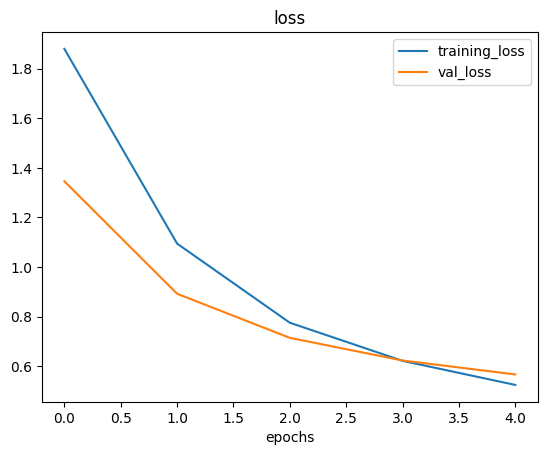

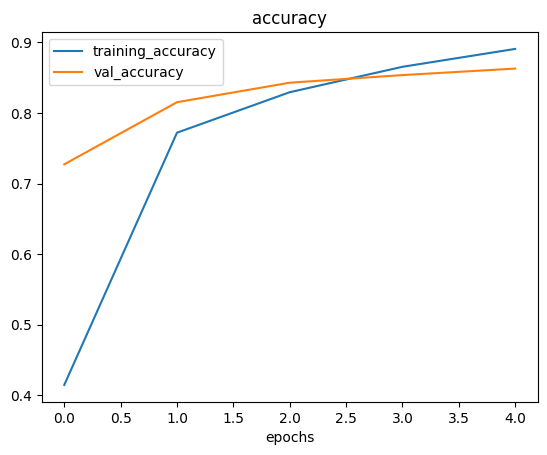

In [ ]:
plot_loss_curves(history=history_2)